In [29]:
library("tidyverse")
library("data.table")
library("cowplot")

In [2]:
set.seed(1)
df <- fread("/nfs/research/birney/users/saul/nextflow/medaka_behaviour_pilot/hmm/time_step0.08_n_states15_hmm.csv.gz")
df[, mean_dist := log10(mean(distance)), by = hmm_state]
tmp <- df[, .(hmm_state, mean_dist)] |> distinct() |> as.data.table()
tmp[, hmm_state_recoded := rank(mean_dist)]
df <- merge(df, tmp, by = c("hmm_state", "mean_dist"))
df[, assay := ifelse(grepl("_no_", id), "Novel object", "Open field")]
df_no <- df[assay == "Novel object"]
df_of <- df[assay == "Open field"]

In [3]:
annot_df <- data.table(
    hmm_state_recoded = 1,
    distance = 1,
    angle = c(0, 90, -90, 180),
    label = c("0", "90", "-90", "±180")
)
annot_df

hmm_state_recoded distance angle label
1 1                 1          0   0    
2 1                 1         90   90   
3 1                 1        -90   -90  
4 1                 1        180   ±180

In [30]:
p1_of <- ggplot() +
    geom_label(data = annot_df, aes(x = angle, y = distance, label = label), size = 5, label.size = NA) +
    geom_point(data = df_of, aes(x = angle/pi*180, y = log10(distance)), shape = ".", alpha = 0.01) +
    coord_polar(start = pi) +
    scale_y_continuous(breaks = c(-3, -1, 1)) +
    scale_x_continuous(
        labels = c(),
        breaks = c(-90, 0, 90, 179.999) # cannot plot exactly 180
    ) +
    facet_wrap(~ hmm_state_recoded, ncol = 1, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    labs(x = "Angle (deg)", y = bquote(Distance~(Log[10](px)))) +
    theme_linedraw(18) +
    theme(
        legend.position = "none",
        panel.background = element_rect(fill = "white"),
        strip.background = element_blank(),
        strip.text = element_text(color = "black"),
        panel.grid.major = element_line(color = "gray30")
    )

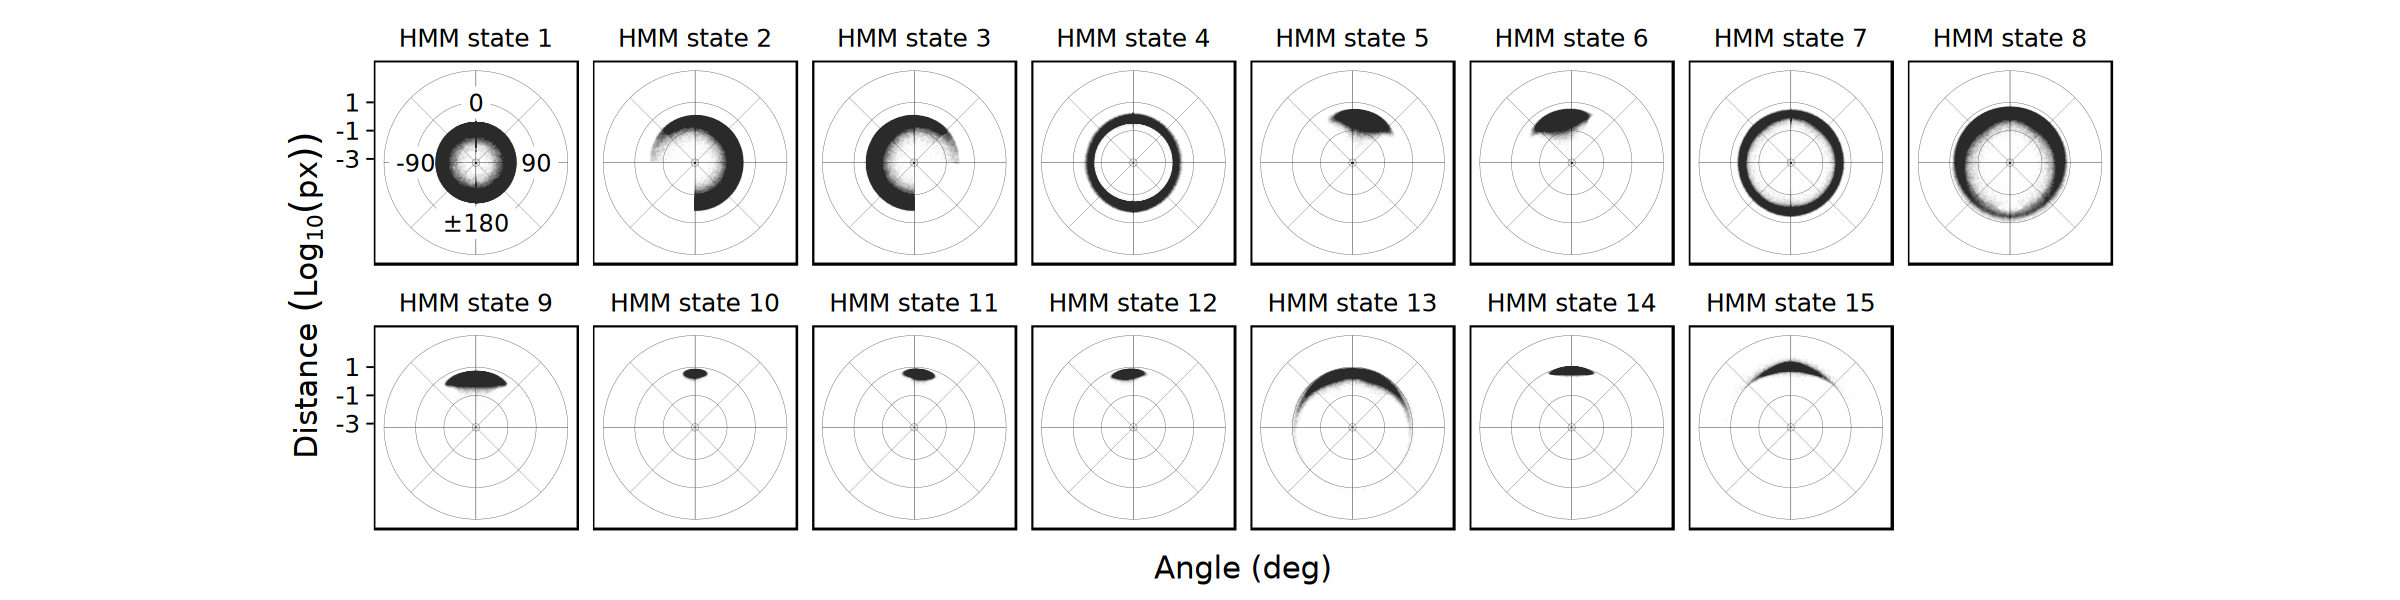

In [44]:
options(repr.plot.width = 20, repr.plot.height = 30)
p1_of

In [31]:
p1_no <- ggplot() +
    geom_label(data = annot_df, aes(x = angle, y = distance, label = label), size = 5, label.size = NA) +
    geom_point(data = df_no, aes(x = angle/pi*180, y = log10(distance)), shape = ".", alpha = 0.01) +
    coord_polar(start = pi) +
    scale_y_continuous(breaks = c(-3, -1, 1)) +
    scale_x_continuous(
        labels = c(),
        breaks = c(-90, 0, 90, 179.999) # cannot plot exactly 180
    ) +
    facet_wrap(~ hmm_state_recoded, ncol = 1, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    labs(x = "Angle (deg)", y = bquote(Distance~(Log[10](px)))) +
    theme_linedraw(18) +
    theme(
        legend.position = "none",
        panel.background = element_rect(fill = "white"),
        strip.background = element_blank(),
        strip.text = element_text(color = "black"),
        panel.grid.major = element_line(color = "gray30")
    )

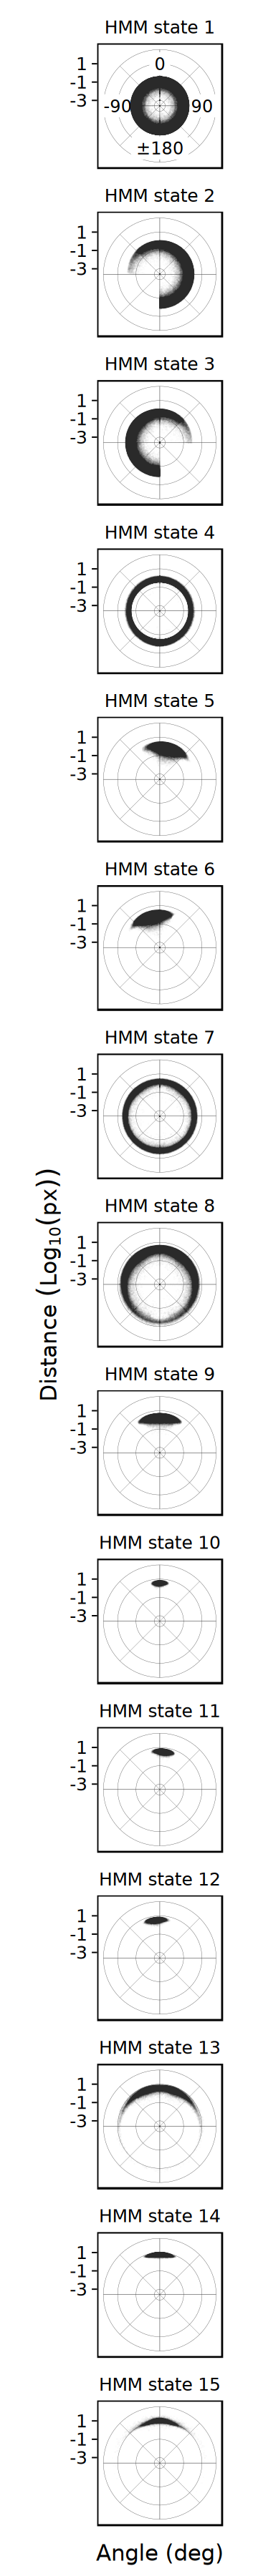

In [7]:
options(repr.plot.width = 3, repr.plot.height = 30)
p1_no

In [6]:
f_list <- list.files("/nfs/research/birney/users/saul/nextflow/medaka_behaviour_pilot/trajectories_csv/", full.names = TRUE)
df_positions <- lapply(f_list, function(f){fread(f)[, id := basename(f) |> str_remove("_traj_with_identities.csv.gz")]}) |> rbindlist(use.names = TRUE)
df_positions[, is_ref_ref := grepl("icab_icab", id)]
df_positions[, frame_n := 1:.N, by = id]
df_positions <- melt(
    df_positions[, .(id, frame_n, ref_x, ref_y, test_x, test_y)],
    id.vars = c("id", "frame_n")
)[
    , .(
        id,
        frame_n,
        axis = str_remove(variable, "^.*_"),
        fish_type = str_remove(variable, "_.*$"),
        value
    )
]
df_positions <- dcast(df_positions, id + frame_n + fish_type ~ axis, measure.var = "value")
df_positions <- df_positions |>
    separate(
        id,
        into = c("date", "time_string", "ref_strain", "test_strain", "tank_side", "assay", "quadrant"),
        sep = "_",
        remove = FALSE
    ) |>
    as.data.table()
df_positions[, id := sprintf("%s_%s", id, fish_type)]
head(df_positions)

id                                   date     time_string ref_strain
1 20190611_1331_icab_icab_R_no_q1_ref  20190611 1331        icab      
2 20190611_1331_icab_icab_R_no_q1_test 20190611 1331        icab      
3 20190611_1331_icab_icab_R_no_q1_ref  20190611 1331        icab      
4 20190611_1331_icab_icab_R_no_q1_test 20190611 1331        icab      
5 20190611_1331_icab_icab_R_no_q1_ref  20190611 1331        icab      
6 20190611_1331_icab_icab_R_no_q1_test 20190611 1331        icab      
  test_strain tank_side assay quadrant frame_n fish_type x        y       
1 icab        R         no    q1       1       ref       226.7195 67.81078
2 icab        R         no    q1       1       test      264.9209 44.03616
3 icab        R         no    q1       2       ref       226.3516 67.53082
4 icab        R         no    q1       2       test      264.9437 44.19932
5 icab        R         no    q1       3       ref       227.1498 68.52848
6 icab        R         no    q1       3       test      264.9437 44.19932

In [7]:
df_merged <- merge(df, df_positions[, assay := NULL], by = c("id", "frame_n"), all.x = TRUE)
head(df_merged)

id                                  frame_n hmm_state mean_dist  time_s   
1 20190611_1331_icab_icab_R_no_q1_ref  3      11        -0.1871935 0.1000000
2 20190611_1331_icab_icab_R_no_q1_ref  5      11        -0.1871935 0.1666667
3 20190611_1331_icab_icab_R_no_q1_ref  7      14        -0.8060102 0.2333333
4 20190611_1331_icab_icab_R_no_q1_ref  9      14        -0.8060102 0.3000000
5 20190611_1331_icab_icab_R_no_q1_ref 11      14        -0.8060102 0.3666667
6 20190611_1331_icab_icab_R_no_q1_ref 13      14        -0.8060102 0.4333333
  distance   angle     hmm_state_recoded assay        date     time_string
1 0.83681897  2.993237 4                 Novel object 20190611 1331       
2 0.37884199  2.356685 4                 Novel object 20190611 1331       
3 0.31815616  2.949842 1                 Novel object 20190611 1331       
4 0.02669565  0.401145 1                 Novel object 20190611 1331       
5 0.07495629  1.065193 1                 Novel object 20190611 1331       
6 0.10567185 -3.103933 1                 Novel object 20190611 1331       
  ref_strain test_strain tank_side quadrant fish_type x        y       
1 icab       icab        R         q1       ref       227.1498 68.52848
2 icab       icab        R         q1       ref       226.9091 68.23593
3 icab       icab        R         q1       ref       227.2257 68.26688
4 icab       icab        R         q1       ref       227.1992 68.26939
5 icab       icab        R         q1       ref       227.1277 68.24675
6 icab       icab        R         q1       ref       227.1068 68.14316

In [8]:
nrow(df) == nrow(df_merged)
df_merged[is.na(x) | is.na(y), .N]

[1] TRUE

[1] 0

In [9]:
df_merged_no <- df_merged[assay == "Novel object"]
df_merged_of <- df_merged[assay == "Open field"]

In [10]:
p2_of <- ggplot(df_merged_of, aes(x = x, y = y)) +
    stat_density_2d(aes(fill = after_stat(density)), geom = "raster", contour = FALSE) +
    scale_x_continuous(expand = expansion(mult = c(0, 0))) +
    scale_y_reverse(expand = expansion(mult = c(0, 0))) + # y is up to down
    scale_fill_distiller(palette = "RdBu", labels = scales::label_scientific(digits = 2)) +
    facet_wrap(~ hmm_state_recoded, ncol = 1, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    labs(y = "Position y (px)", x = "Position x (px)", fill = "Density") +
    theme_cowplot(18) +
    theme(
        axis.line = element_blank(),
        strip.background = element_blank(),
        panel.background = element_rect(fill = "gray"),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.title.y = element_text(margin = margin(r = 10)),
        axis.text = element_text(size = 9),
        legend.position = "right",
    )

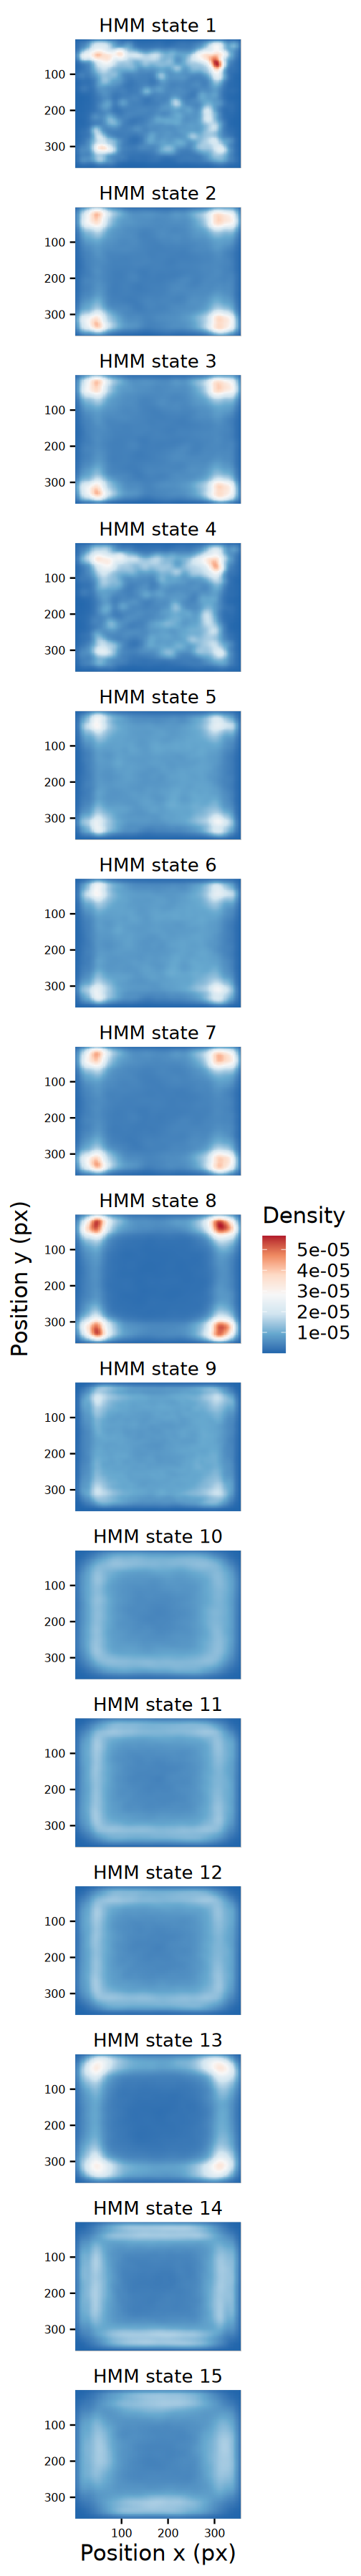

In [13]:
options(repr.plot.width = 4.2, repr.plot.height = 30)
p2_of

In [11]:
p2_no <- ggplot(df_merged_no, aes(x = x, y = y)) +
    stat_density_2d(aes(fill = after_stat(density)), geom = "raster", contour = FALSE) +
    scale_x_continuous(expand = expansion(mult = c(0, 0))) +
    scale_y_reverse(expand = expansion(mult = c(0, 0))) + # y is up to down
    scale_fill_distiller(palette = "RdBu", labels = scales::label_scientific(digits = 2)) +
    facet_wrap(~ hmm_state_recoded, ncol = 1, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    labs(y = "Position y (px)", x = "Position x (px)", fill = "Density") +
    theme_cowplot(18) +
    theme(
        axis.line = element_blank(),
        strip.background = element_blank(),
        panel.background = element_rect(fill = "gray"),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.title.y = element_text(margin = margin(r = 10)),
        axis.text = element_text(size = 9),
    )

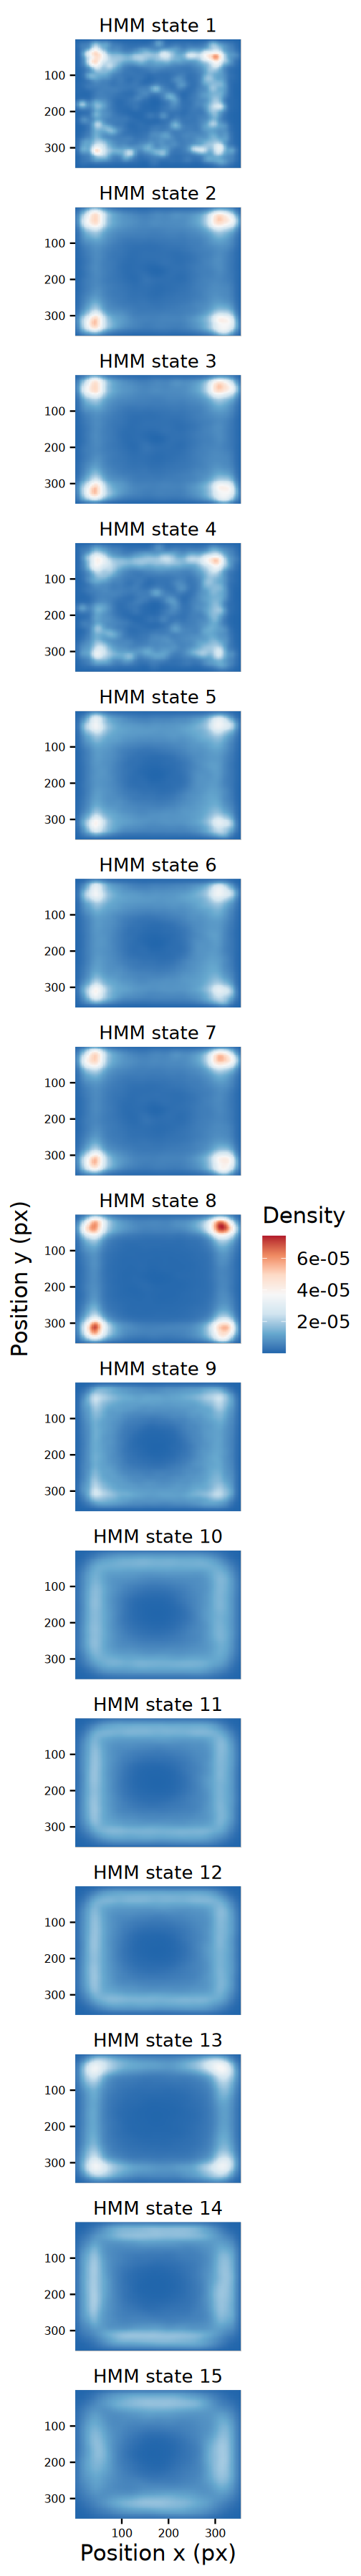

In [15]:
options(repr.plot.width = 4.2, repr.plot.height = 30)
p2_no

In [12]:
# background density after habituation period (400 seconds)
n_points <- 100
df_bkg_of <- df_merged_of[time_s > 400]
df_bkg_no <- df_merged_no[time_s > 400]
xrng <- range(df_merged[["x"]])
yrng <- range(df_merged[["y"]])
kde_bkg <- list(
    "Open field" = MASS::kde2d(df_bkg_of[["x"]], df_bkg_of[["y"]], lims=c(xrng, yrng), n=n_points),
    "Novel object" = MASS::kde2d(df_bkg_no[["x"]], df_bkg_no[["y"]], lims=c(xrng, yrng), n=n_points)
)

In [13]:
get_state_density_diff <- function(the_state, the_assay){
    # difference in density per state compare to background
    tmp <- df_merged[assay == the_assay & hmm_state_recoded == the_state]
    kde_bkg_tmp <- kde_bkg[[the_assay]]
    kde_state <- MASS::kde2d(tmp[["x"]], tmp[["y"]], lims=c(xrng, yrng), n=n_points)
    stopifnot(identical(kde_bkg_tmp$x, kde_state$x) & identical(kde_bkg_tmp$y, kde_state$y))
    tmp2 <- data.table(kde_state[["z"]] - kde_bkg_tmp[["z"]])
    
    # rows correspond to the value of x, columns to the value of y
    colnames(tmp2) <- as.character(kde_bkg_tmp[["y"]])
    tmp2[, x := kde_bkg_tmp[["x"]]]
    tmp2 <- melt(tmp2, id.vars = "x", value.name = "density", variable.name = "y")
    tmp2[, y := as.numeric(as.character(y))]
    tmp2[, hmm_state_recoded := the_state]
    return(tmp2)
}

In [14]:
df_diff_of <- lapply(df_merged[, unique(hmm_state_recoded)], get_state_density_diff, the_assay = "Open field") |> rbindlist()

In [15]:
df_diff_no <- lapply(df_merged[, unique(hmm_state_recoded)], get_state_density_diff, the_assay = "Novel object") |> rbindlist()

In [16]:
dmax_of <- df_diff_of[, range(density) |> abs() |> max()]
dmax_no <- df_diff_no[, range(density) |> abs() |> max()]

In [17]:
p3_of <- ggplot(df_diff_of, aes(x = x, y = y, fill = density)) +
    geom_tile() +
    scale_x_continuous(expand = expansion(mult = c(0, 0))) +
    scale_y_reverse(expand = expansion(mult = c(0, 0))) + # y is up to down
    scale_fill_distiller(palette = "RdBu", labels = scales::label_scientific(digits = 2), limit = c(-dmax_of, dmax_of)) +
    facet_wrap(~hmm_state_recoded, ncol = 1, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    theme_cowplot(18) +
    labs(y = "Position y (px)", x = "Position x (px)", fill = "Density\ndifference   ") +
    theme(
        axis.line = element_blank(),
        strip.background = element_blank(),
        panel.background = element_rect(fill = "gray"),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.title.y = element_text(margin = margin(r = 10)),
        axis.text = element_text(size = 9),
    )

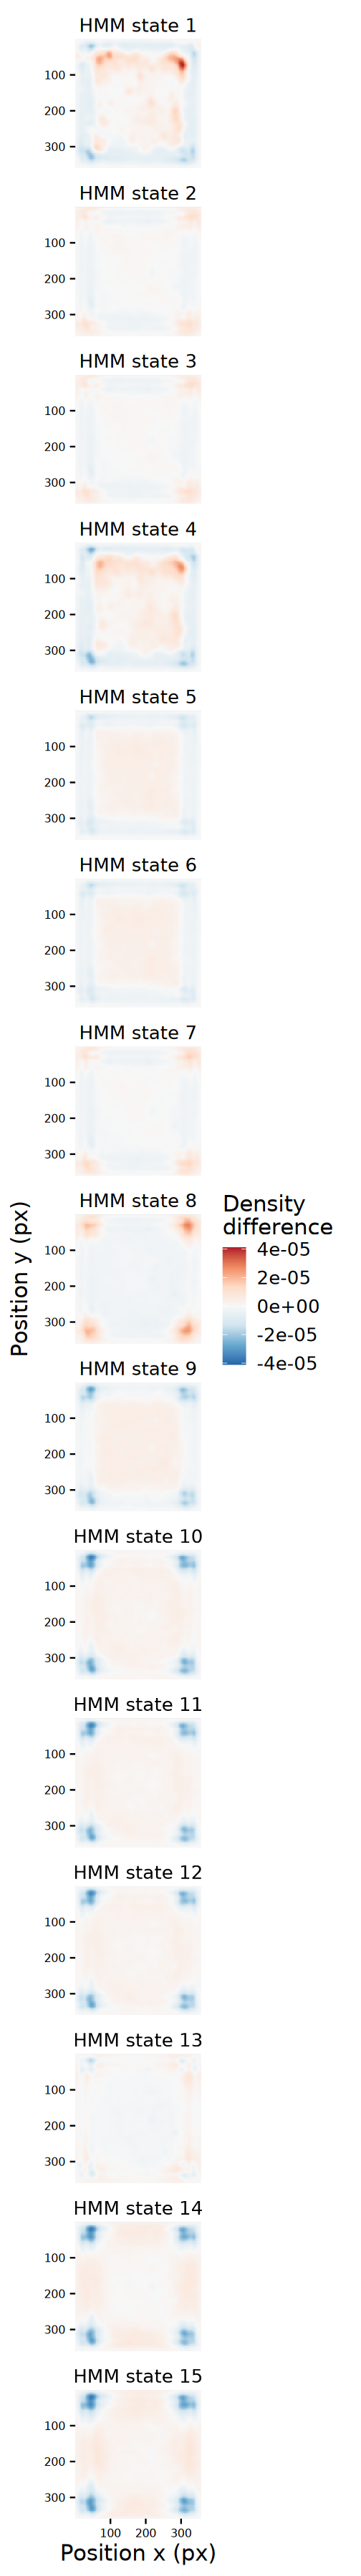

In [22]:
options(repr.plot.width = 4.2, repr.plot.height = 30)
p3_of

In [18]:
p3_no <- ggplot(df_diff_no, aes(x = x, y = y, fill = density)) +
    geom_tile() +
    scale_x_continuous(expand = expansion(mult = c(0, 0))) +
    scale_y_reverse(expand = expansion(mult = c(0, 0))) + # y is up to down
    scale_fill_distiller(palette = "RdBu", labels = scales::label_scientific(digits = 2), limit = c(-dmax_no, dmax_no)) +
    facet_wrap(~hmm_state_recoded, ncol = 1, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    theme_cowplot(18) +
    labs(y = "Position y (px)", x = "Position x (px)", fill = "Density\ndifference   ") +
    theme(
        axis.line = element_blank(),
        strip.background = element_blank(),
        panel.background = element_rect(fill = "gray"),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.title.y = element_text(margin = margin(r = 10)),
        axis.text = element_text(size = 9)
    )

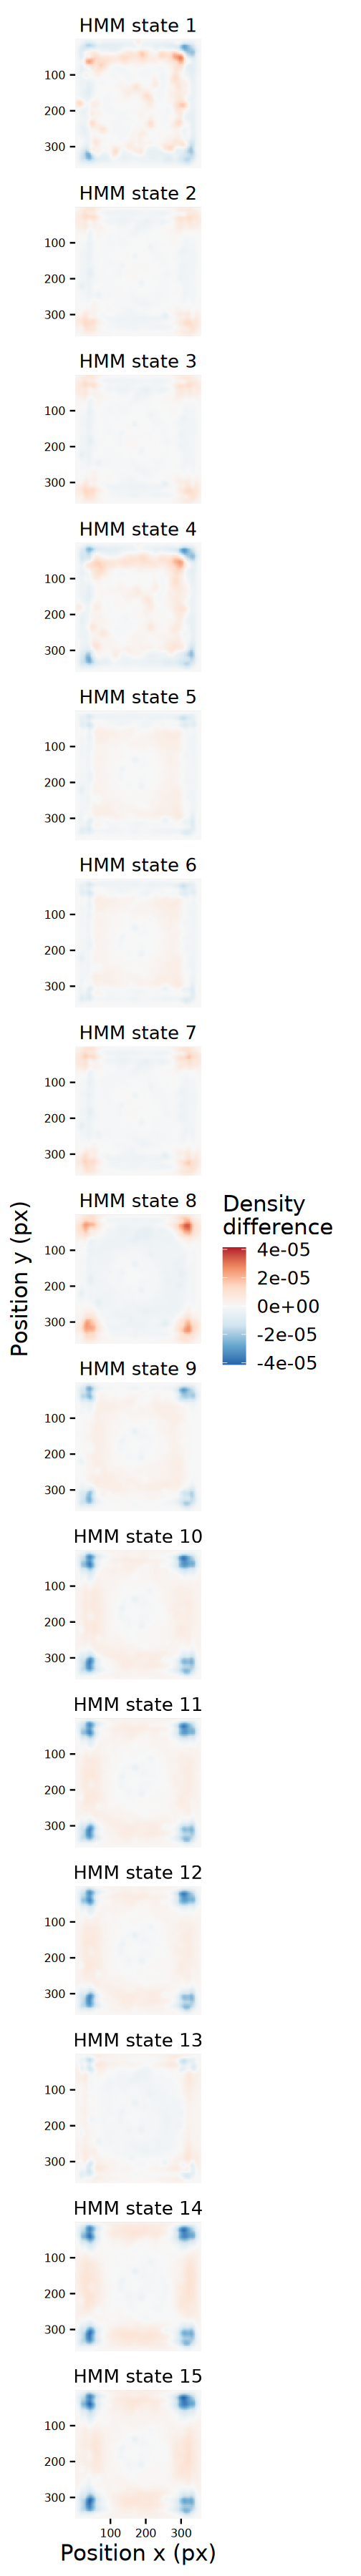

In [24]:
options(repr.plot.width = 4.2, repr.plot.height = 30)
p3_no

In [19]:
df_timeseries <- df[
    , .(assay, hmm_state_recoded, time_step = as.numeric(as.character(cut(time_s, seq(0, 600, 50), labels = seq(25, 575, 50)))))
][
    , .(n = .N), by = c("assay", "hmm_state_recoded", "time_step")
][
    , .(hmm_state_recoded = unique(hmm_state_recoded), f = n / sum(n)), by = c("assay", "time_step")
]

head(df_timeseries)

assay        time_step hmm_state_recoded f          
1 Novel object 25         6                0.050309247
2 Novel object 25        10                0.005874046
3 Novel object 25        11                0.016433318
4 Novel object 25         3                0.041893356
5 Novel object 25         9                0.070260862
6 Novel object 25         2                0.041383236

In [20]:
p4_of <- ggplot(df_timeseries[assay == "Open field"], aes(x = time_step, y = f*100)) +
    geom_line() +
    facet_wrap(~hmm_state_recoded, ncol = 1, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    theme_cowplot(18) +
    scale_x_continuous(breaks = seq(100, 600, 200)) +
    labs(color = "", x = "Time (s)", y = "Usage (%)") +
    theme(
        axis.line = element_blank(),
        strip.background = element_blank(),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.title.y = element_text(margin = margin(r = 10))
    )

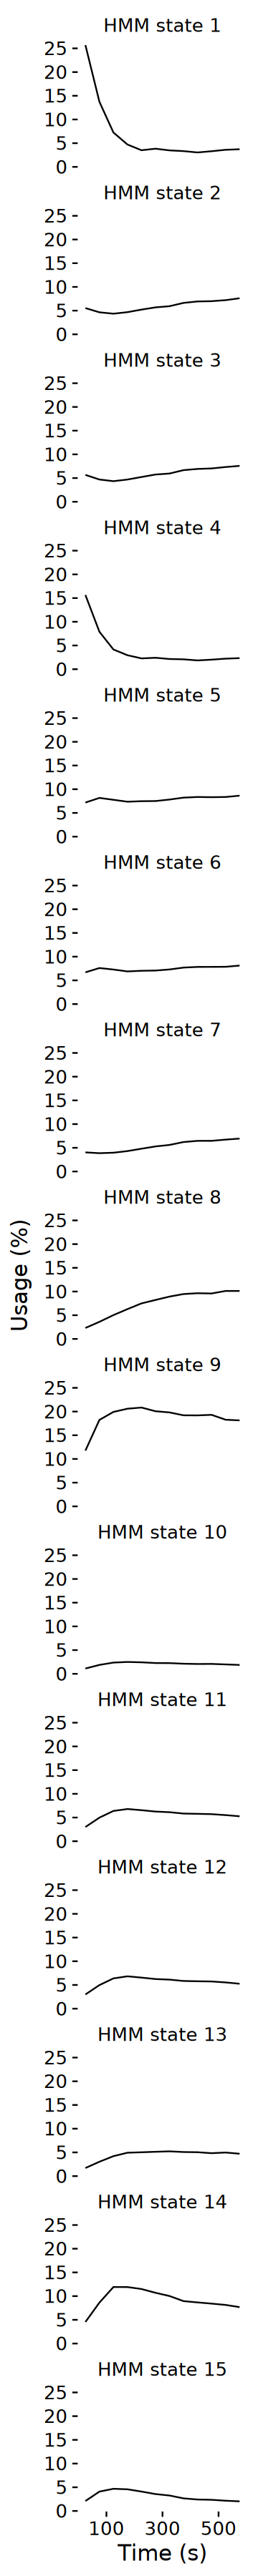

In [21]:
options(repr.plot.width = 3, repr.plot.height = 30)
p4_of

In [22]:
p4_no <- ggplot(df_timeseries[assay == "Novel object"], aes(x = time_step, y = f*100)) +
    geom_line() +
    facet_wrap(~hmm_state_recoded, ncol = 1, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    theme_cowplot(18) +
    scale_x_continuous(breaks = seq(100, 600, 200)) +
    labs(color = "", x = "Time (s)", y = "Usage (%)") +
    theme(
        axis.line = element_blank(),
        strip.background = element_blank(),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.title.y = element_text(margin = margin(r = 10))
    )

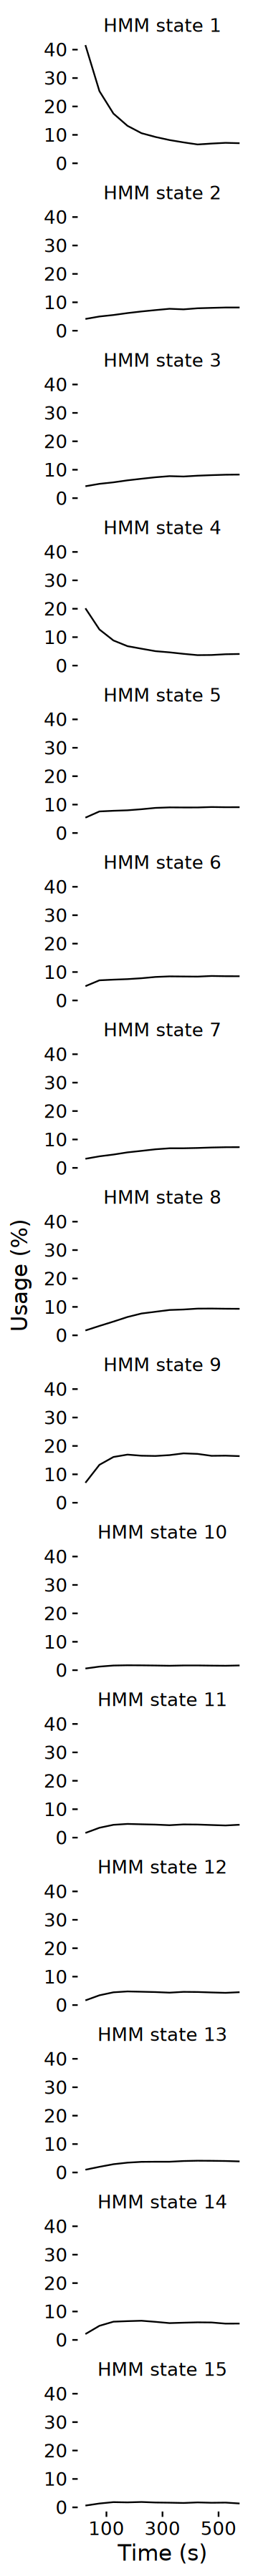

In [29]:
options(repr.plot.width = 3, repr.plot.height = 30)
p4_no

In [32]:
p_of <- plot_grid(
    plot_grid(p1_of, NULL, ncol = 1, rel_heights = c(500, 1)), 
    NULL, 
    plot_grid(NULL, p2_of, ncol = 1, rel_heights = c(1, 500)),
    NULL,
    plot_grid(NULL, p3_of, ncol = 1, rel_heights = c(1, 500)),
    NULL,
    p4_of,
    nrow = 1,
    rel_widths = c(2.9, 0.5, 4.15, 0.5, 4.5, 0.5, 3),
    labels = c("A", "", "B", "", "C", "", "D"),
    align = "vertical",
    axis = "tb"
)

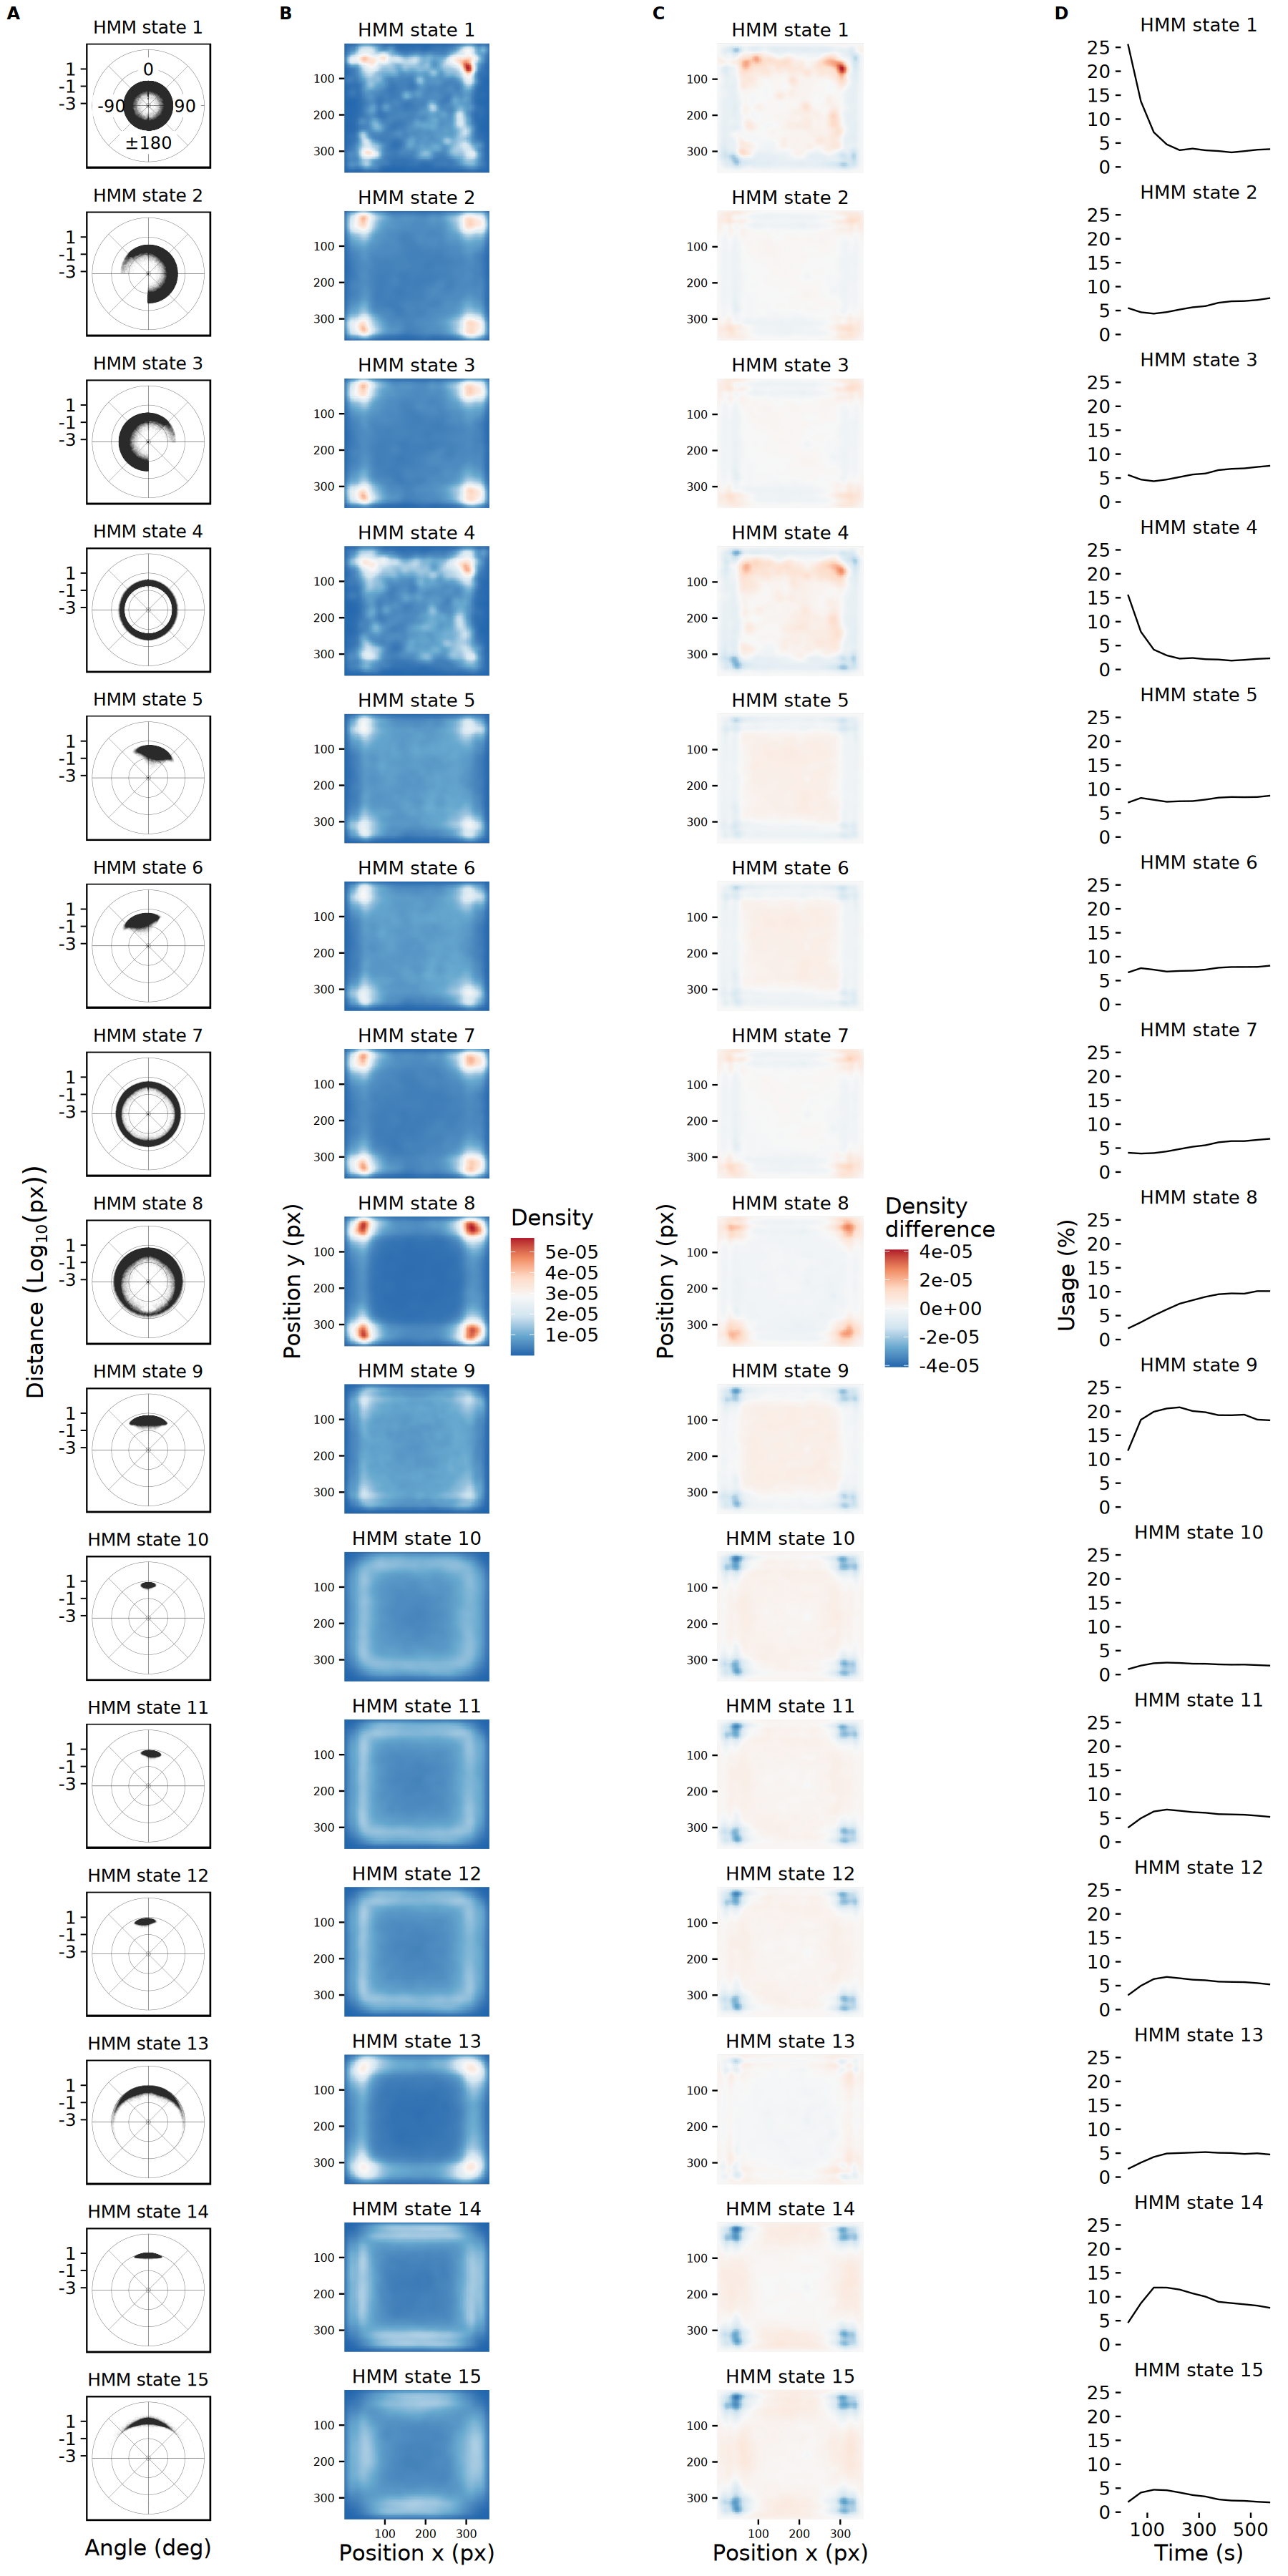

In [33]:
options(repr.plot.width = 15, repr.plot.height = 30)
p_of

In [34]:
ggsave(
    "figS2.pdf",
    p_of,
    width = 15,
    height = 30
)

In [35]:
p_no <- plot_grid(
    plot_grid(p1_no, NULL, ncol = 1, rel_heights = c(500, 1)), 
    NULL, 
    plot_grid(NULL, p2_no, ncol = 1, rel_heights = c(1, 500)),
    NULL,
    plot_grid(NULL, p3_no, ncol = 1, rel_heights = c(1, 500)),
    NULL,
    p4_no,
    nrow = 1,
    rel_widths = c(2.9, 0.5, 4.15, 0.5, 4.5, 0.5, 3),
    labels = c("A", "", "B", "", "C", "", "D"),
    align = "vertical",
    axis = "tb"
)

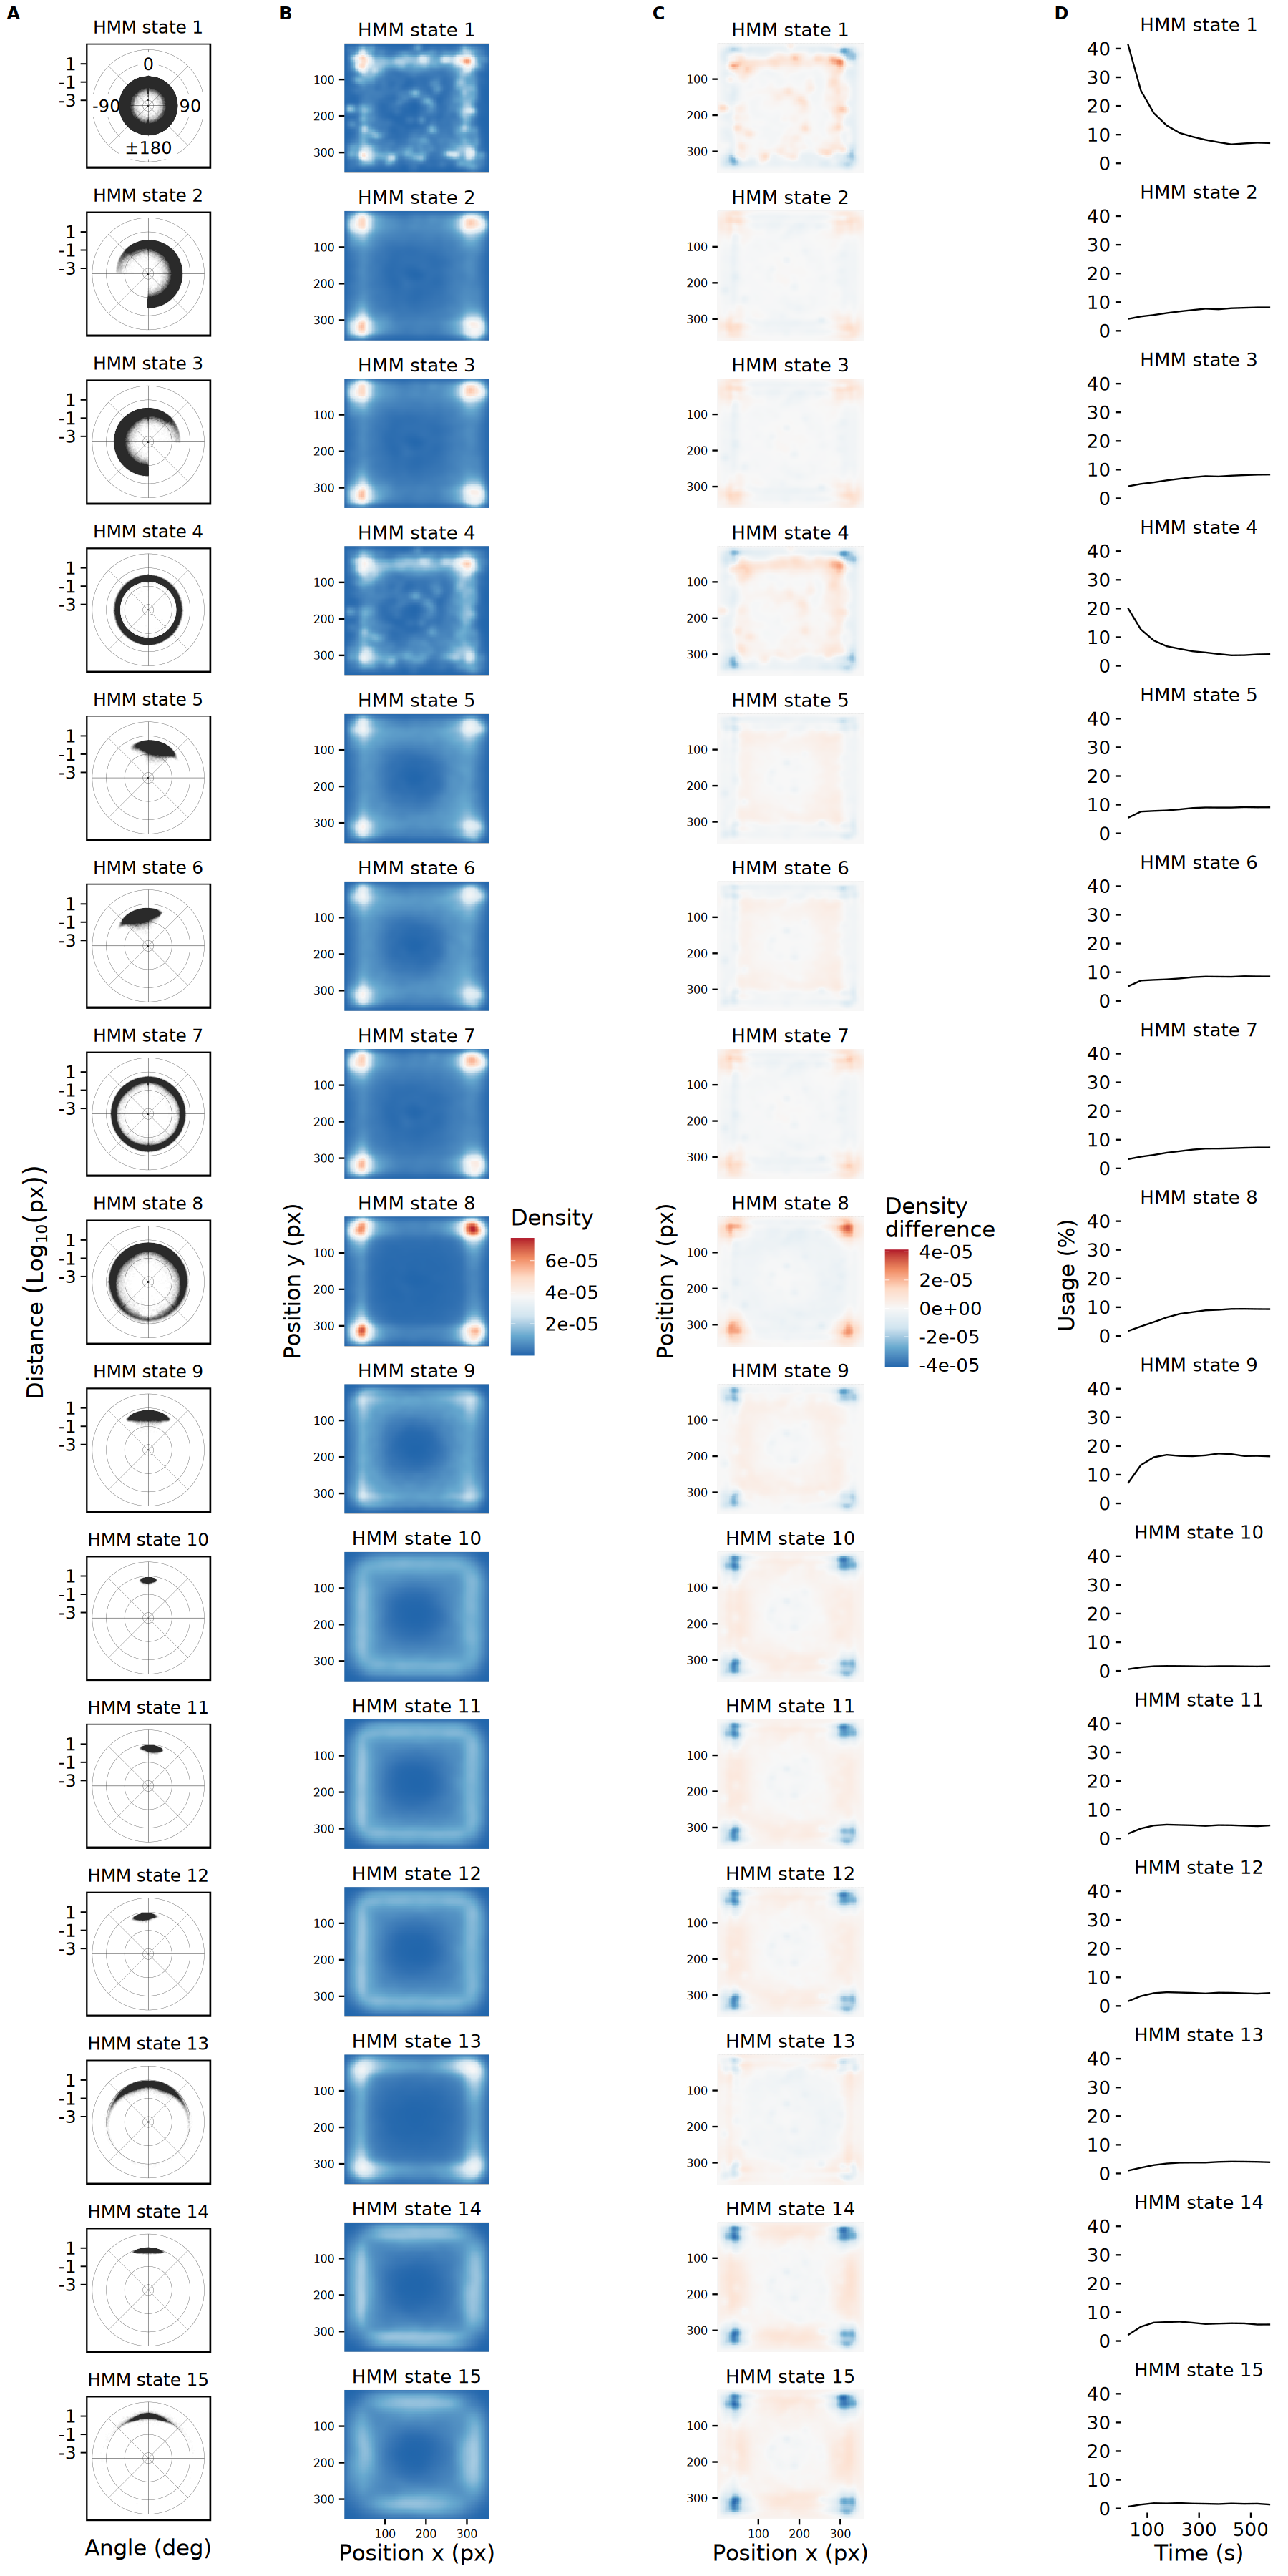

In [36]:
options(repr.plot.width = 15, repr.plot.height = 30)
p_no

In [37]:
ggsave(
    "figS3.pdf",
    p_no,
    width = 15,
    height = 30
)